In [4]:
from diffusers import LDMSuperResolutionPipeline
from diffusers.pipelines.latent_diffusion.pipeline_latent_diffusion_superresolution import preprocess

from dataset import CoverDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models import get_models
import albumentations as A
import torch
from defs import *
from diffusers import DDPMScheduler, DDPMPipeline
from evaluate import evaluate, make_grid
import numpy as np


/root/anaconda3/envs/album/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Definding seed and device

In [5]:
DEVICE = 'cuda:0'
SEED = 231
MODEL_PATH = "results/weights/unet"

## Getting Diffusion model

In [6]:
model = get_models(IMSIZE).to(DEVICE)
model = model.from_pretrained(MODEL_PATH)
model.sample_size = 128
model = model.to(DEVICE)
model.eval()
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
generator = torch.Generator(device=DEVICE)
generator = generator.manual_seed(SEED)

## Generate 128x128 images

In [ ]:
images = pipeline(
    batch_size=4,
    generator=generator,
).images

## Getting Super Resolution model

In [ ]:
rescaler_id = "CompVis/ldm-super-resolution-4x-openimages"
rescaler = LDMSuperResolutionPipeline.from_pretrained(rescaler_id)
rescaler = rescaler.to(DEVICE)

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 6023.41it/s]


## Upscale to 512x512

In [ ]:
images = [preprocess(i) for i in images]
images = torch.cat(images)
upscaled_images = rescaler(images, num_inference_steps=100, eta=1)

100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


## Visualize

In [ ]:
grid = make_grid(upscaled_images.images, 2, 2)

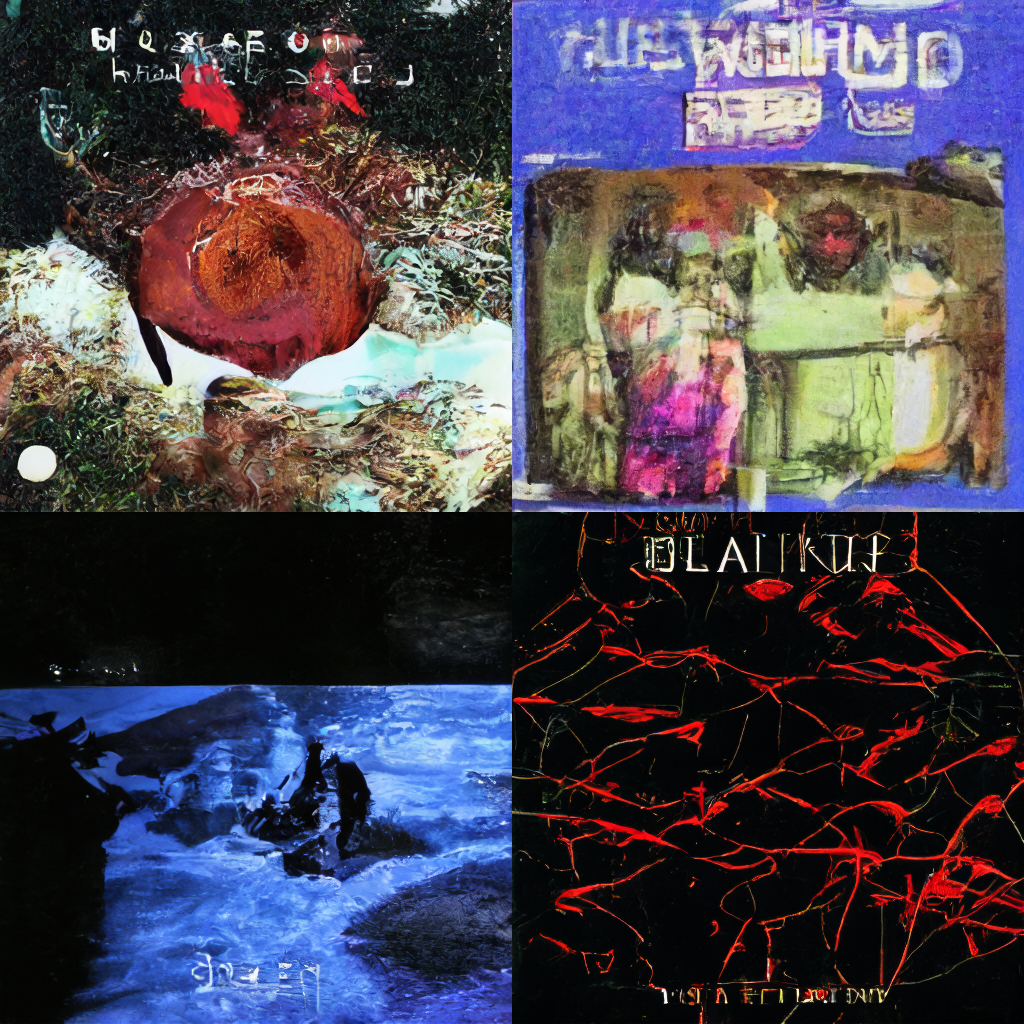

In [ ]:
grid